In [1]:
import pandas as pd
import numpy as np

In [2]:
!DIR

 Volume in drive C has no label.
 Volume Serial Number is 7475-1D8D

 Directory of C:\Users\seidm\leuven\2\riks\ass1\learning

04/22/2023  02:55 PM    <DIR>          .
04/22/2023  02:55 PM    <DIR>          ..
04/22/2023  02:55 PM    <DIR>          .ipynb_checkpoints
04/22/2023  09:58 AM            17,972 data.txt
04/22/2023  10:01 AM            26,693 data.xlsx
04/22/2023  02:38 PM           522,190 learning.ipynb
04/22/2023  02:55 PM                72 Untitled.ipynb
               4 File(s)        566,927 bytes
               3 Dir(s)  17,336,209,408 bytes free


In [3]:
df = pd.read_excel('data.xlsx')
prices= df.drop('Date', axis=1)

In [4]:
BEL20 = 5000
AEX = 5000
CAC40 = 4000

TOTAL = BEL20 + AEX + CAC40

In [5]:
daily_returns = prices.pct_change(1).tail(-1)
N = len(daily_returns)

In [6]:
daily_returns.round(3)

,Bel 20,AEX,CAC40
1,0.004,0.005,0.012
2,0.005,0.002,0.002
3,0.011,-0.003,0.006
4,0.005,0.002,-0.005
5,0.003,-0.003,-0.005
...,...,...,...
496,-0.005,0.002,-0.003
497,0.022,0.012,0.027
498,0.006,-0.012,-0.002
499,-0.001,-0.004,-0.002


In [7]:
investment_values = (1 + daily_returns) * [BEL20, AEX, CAC40]
investment_values['Portfolio'] = investment_values.sum(axis=1)
investment_values.round(2)

,Bel 20,AEX,CAC40,Portfolio
1,5020.13,5023.17,4048.84,14092.13
2,5022.96,5008.85,4006.09,14037.89
3,5057.21,4984.86,4025.30,14067.37
4,5026.63,5011.07,3979.25,14016.95
5,5015.65,4983.27,3980.45,13979.37
...,...,...,...,...
496,4973.68,5010.45,3987.67,13971.80
497,5108.70,5059.98,4106.28,14274.96
498,5030.08,4938.99,3992.58,13961.64
499,4993.23,4978.34,3993.95,13965.51


In [8]:
pnl = investment_values['Portfolio'] - TOTAL

#### Plot PNL

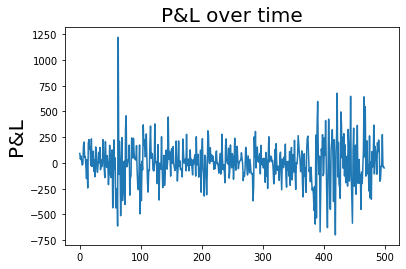

In [9]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(range(0, N), pnl)
plt.ylabel('P&L', fontsize=20)
plt.title('P&L over time', fontsize=20)
plt.show()

In [10]:
def count_cumulitive_likelihood(likelihood):
    cum_lklhd = [likelihood[0]]
    for i in range(1, len(likelihood)):
        cum_lklhd.append(cum_lklhd[i-1] + likelihood[i])
        
    return cum_lklhd

def get_ranked_pnl(likelihood, pnl=pnl):
    ranked_pnl = pd.DataFrame({
    'PnL': pnl,
    'Weight' : likelihood
    })
    ranked_pnl = ranked_pnl.sort_values(by=['PnL'])
    ranked_pnl['Cumulative_likelihood'] = count_cumulitive_likelihood(ranked_pnl['Weight'].array)
    return ranked_pnl

In [11]:
def calculate_abs_var(ranked_pnl, c=0.01):
    for _, row in ranked_pnl.iterrows():
        if c < row['Cumulative_likelihood']:
            return -row['PnL']
    
    
def calculate_relative_var(ranked_pnl, c=.01):
    abs_VaR = calculate_abs_var(ranked_pnl)
    return_VaR = -abs_VaR / TOTAL
    return_expected = ranked_pnl['PnL'].mean() / TOTAL
    return TOTAL * (return_expected - return_VaR)

### Equal weights

In [14]:
likelihood = [1/N for _ in  range(N)]
default_pnl = get_ranked_pnl(likelihood)
calculate_abs_var(default_pnl), calculate_relative_var(default_pnl)

(585.8652584657011, 585.1286763875441)

In [15]:
default_pnl.round(3)

,PnL,Weight,Cumulative_likelihood
420,-699.228,0.002,0.002
395,-670.314,0.002,0.004
407,-628.731,0.002,0.006
63,-612.611,0.002,0.008
387,-594.241,0.002,0.010
...,...,...,...
391,596.885,0.002,0.992
467,642.381,0.002,0.994
445,648.055,0.002,0.996
423,677.857,0.002,0.998


### Exponential declining weights

In [16]:
def get_exponential_weight(alpha, i, n=N):
    return alpha**(n - i) * (1 - alpha) / (1 - alpha**n)

def get_exponential_weights(alpha, n=N):
    return np.array(
        [get_exponential_weight(alpha, i, n) for i in range(1, n+1)]
    )

In [17]:
alpha = .99
likelihood = get_exponential_weights(alpha)
exp_ranked_pnl = get_ranked_pnl(likelihood)

In [21]:
exp_ranked_pnl.round(3).head()

,PnL,Weight,Cumulative_likelihood
420,-699.228,0.005,0.005
395,-670.314,0.004,0.008
407,-628.731,0.004,0.012
63,-612.611,0.000,0.012
387,-594.241,0.003,0.015


In [22]:
calculate_abs_var(exp_ranked_pnl), calculate_relative_var(exp_ranked_pnl)

(628.7310014230407, 627.9944193448837)

In [23]:
X = [0.008, 0.012]
Y = [-628.731, -612.611]
np.interp(0.01, X, Y)

-620.671

In [24]:
daily_returns

,Bel 20,AEX,CAC40
1,0.004025,0.004634,0.012209
2,0.004592,0.001769,0.001522
3,0.011441,-0.003028,0.006325
4,0.005326,0.002214,-0.005188
5,0.003130,-0.003346,-0.004888
...,...,...,...
496,-0.005264,0.002089,-0.003082
497,0.021741,0.011996,0.026569
498,0.006016,-0.012203,-0.001856
499,-0.001355,-0.004332,-0.001513


### EWMA

In [25]:
daily_returns['Bel 20']

1      0.004025
2      0.004592
3      0.011441
4      0.005326
5      0.003130
         ...   
496   -0.005264
497    0.021741
498    0.006016
499   -0.001355
500   -0.005652
Name: Bel 20, Length: 500, dtype: float64

In [26]:
def forecast_variance(returns, initial_value, alpha):
    variance_forecast = [initial_value]

    for i in range(1, N+1):
        forecast = alpha * variance_forecast[i-1]  +  (1 - alpha) * returns.iloc[i-1] **2 
        variance_forecast.append(forecast)
    
    return np.array(variance_forecast)
    
def forecast_volatility(returns, initial_value, alpha=.95):
    return forecast_variance(returns, initial_value, alpha) ** .5

In [27]:
alpha = .95

bel20_initial_variance = 0.000202069840303067
aex_initial_variance = 0.000182313302111389
cac40_initial_variance = 0.000273478133204299

volatility_forecast = pd.DataFrame({
    'Bel 20': forecast_volatility(daily_returns['Bel 20'], bel20_initial_variance, alpha),
    'AEX': forecast_volatility(daily_returns['AEX'], aex_initial_variance, alpha),
    'CAC40': forecast_volatility(daily_returns['CAC40'], cac40_initial_variance, alpha),
})

In [28]:
volatility_forecast.columns

Index(['Bel 20', 'AEX', 'CAC40'], dtype='object')

In [33]:
latest_volatility_forecast = volatility_forecast.tail(1)

volatility_adjusted_returns = pd.DataFrame()

to_invest = [BEL20, AEX, CAC40]
n = len(daily_returns.columns)

for i in range(n):
    col = daily_returns.columns[i]
    tmp = (latest_volatility_forecast[col][N] / volatility_forecast[col].head(N))
    volatility_adjusted_returns[col] = to_invest[i] * (1 + daily_returns[col].reset_index(drop=True) * tmp.reset_index(drop=True))
    

In [30]:
vol_adjusted_portfolio = volatility_adjusted_returns.sum(axis=1)
vol_adjusted_pnl = vol_adjusted_portfolio - TOTAL

In [29]:
likelihood = [1/N for _ in  range(N)]
ranked_vol_adjusted_pnl = get_ranked_pnl(likelihood, pnl=vol_adjuste_pnl)
calculate_abs_var(ranked_vol_adjusted_pnl)

528.8687968221311

In [31]:
ranked_vol_adjusted_pnl.round(3)

,PnL,Weight,Cumulative_likelihood
284,-728.180,0.002,0.002
54,-698.141,0.002,0.004
62,-638.634,0.002,0.006
386,-593.193,0.002,0.008
59,-545.831,0.002,0.010
...,...,...,...
233,478.490,0.002,0.992
444,484.574,0.002,0.994
466,498.415,0.002,0.996
145,526.186,0.002,0.998


Text(0.5, 1.0, 'EWMA volatilities')

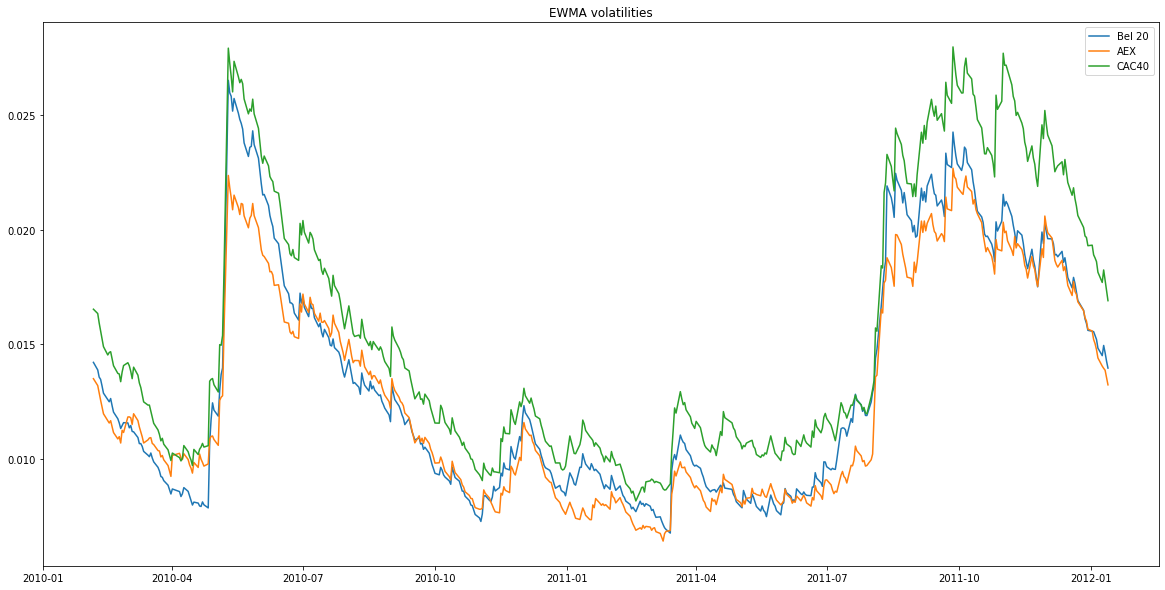

In [32]:
plt.rcParams["figure.figsize"] = (20,10)


for col in volatility_forecast.columns:
    plt.plot(df['Date'], volatility_forecast[col], label=col)
    
plt.legend()
plt.title('EWMA volatilities')

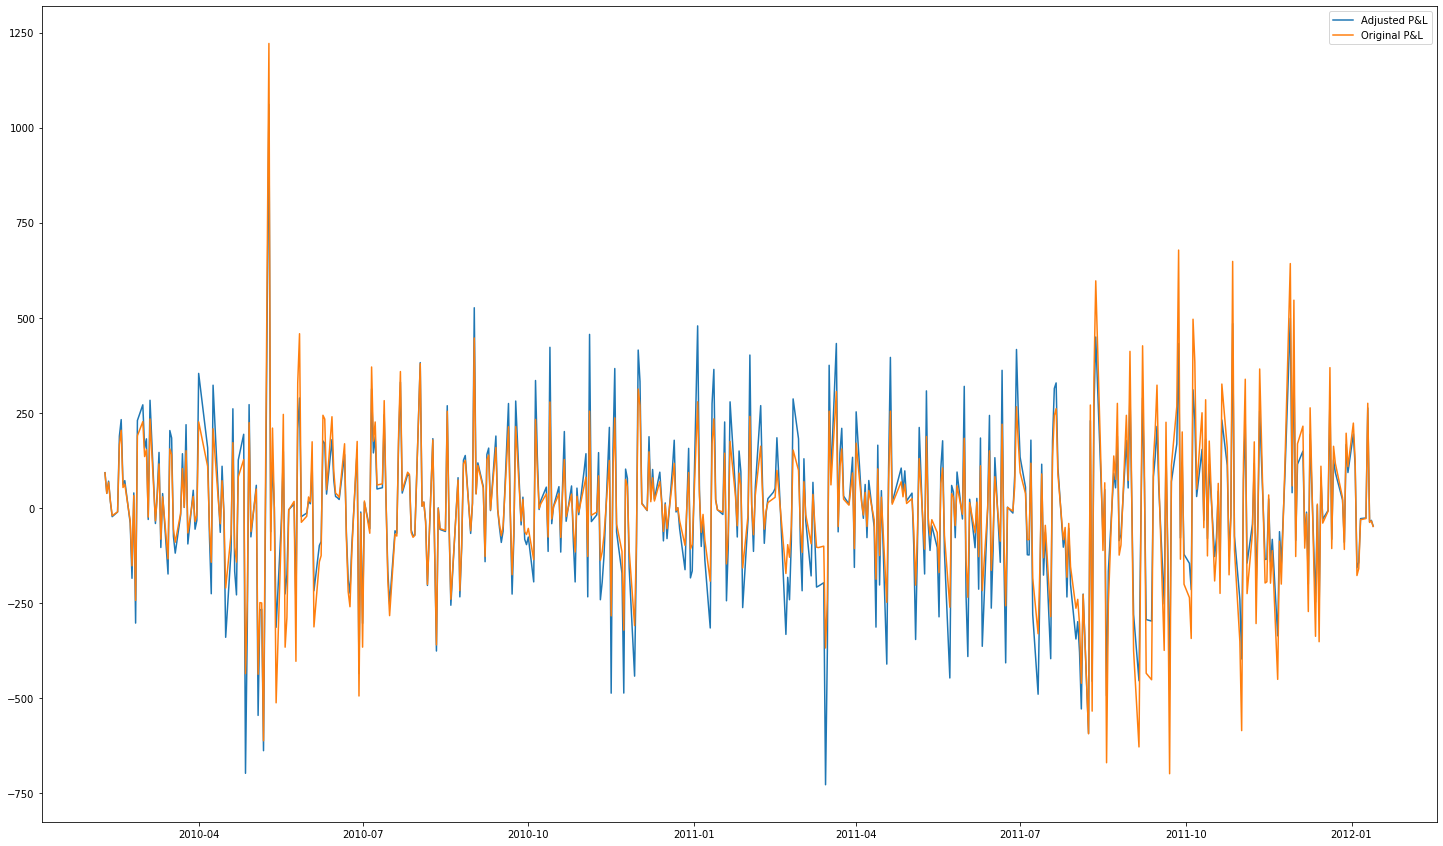

In [40]:
plt.rcParams["figure.figsize"] = (25,15)


plt.plot(df['Date'].tail(-1), vol_adjusted_pnl, label='Adjusted P&L')
plt.plot(df['Date'].tail(-1), pnl, label='Original P&L')
plt.legend()
plt.show()

In [ ]:
vol_adjuste_pnl